In [3]:
!pip install pennylane

100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


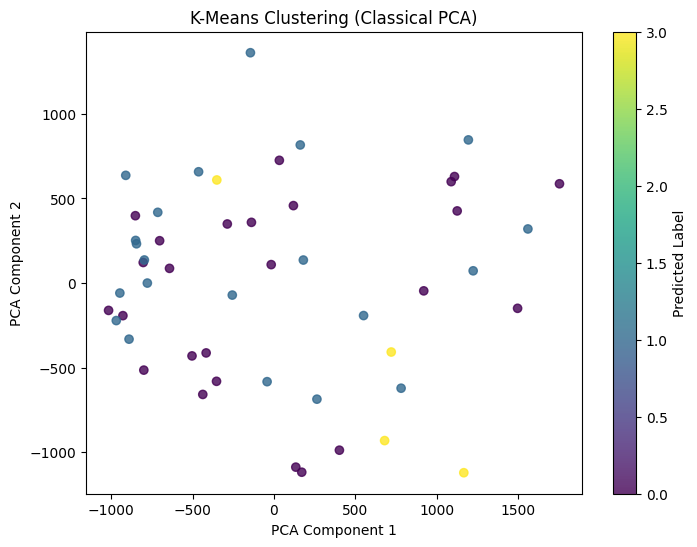

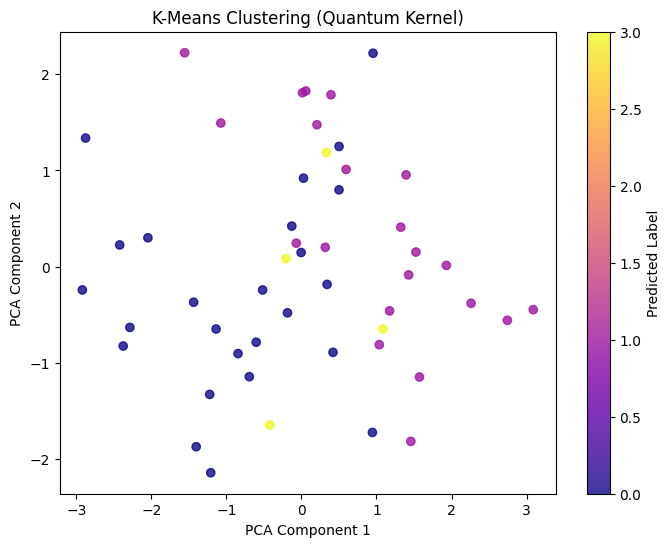

Silhouette Score (Classical PCA-reduced): -0.11513241040713083
Silhouette Score (Quantum Kernel): 0.1200792136719653
Quantum Kernel Classification Accuracy: 0.34


In [11]:
# Import necessary libraries
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.optimize import minimize
from scipy.stats import mode

# ✅ Set Quantum Device with CPU Execution
n_qubits = 6
n_layers = 3
size=50
dev = qml.device("default.qubit", wires=n_qubits)

# ✅ Define Quantum Circuit Components
# def feature_map(x):
#     for i in range(n_qubits):
#         qml.Hadamard(wires=i)
#         qml.RY(x[i], wires=i)
#         qml.RZ(x[i], wires=i)

# def variational_ansatz(params):
#     for l in range(n_layers):
#         for i in range(n_qubits):
#             qml.RY(params[l * n_qubits + i], wires=i)
#             qml.CNOT(wires=[i, (i+1) % n_qubits])
#             qml.RZ(params[l * n_qubits + i], wires=i)
#         qml.Barrier()


def feature_map(x):
    """Encodes classical data into a quantum state using RX, RY, and RZ rotations."""
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
        qml.RY(x[i], wires=i)
        qml.RZ(x[i], wires=i)

def entanglement_layer():
    """Applies CZ gates for stronger qubit entanglement."""
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    qml.CZ(wires=[n_qubits - 1, 0])  # Closing the entanglement loop

def variational_ansatz(params):
    """A deeper, more expressive variational quantum circuit."""
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RY(params[l * n_qubits + i], wires=i)
            qml.RX(params[l * n_qubits + i], wires=i)
            qml.RZ(params[l * n_qubits + i], wires=i)
        entanglement_layer()  # Apply entanglement after each layer


# ✅ Quantum Kernel Function - Measure All Qubits
@qml.qnode(dev)
def quantum_kernel(x1, x2, params):
    feature_map(x1)
    variational_ansatz(params)
    qml.adjoint(feature_map)(x2)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# ✅ Load MNIST Dataset and Extract 6 Classes
(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28)  # Flatten images

# Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
selected_classes = [0, 1, 2, 3, 4, 5]
mask = np.isin(y_train, selected_classes)
X, y_true = X_train[mask], y_train[mask]

# Reduce dataset size for faster computation
X, y_true = X[:size], y_true[:size]

# ✅ Apply PCA to Reduce Dimensionality
X = PCA(n_components=n_qubits).fit_transform(X)  # Reduce to `n_qubits` dimensions

# ✅ Compute Kernel Matrix Sequentially
def batch_kernel(X, params):
    N = len(X)
    kernel_matrix = np.zeros((N, N, n_qubits))  # Store full qubit measurements

    for i in tqdm(range(N)):
        for j in range(N):
            kernel_matrix[i, j] = quantum_kernel(X[i], X[j], params)
    
    return kernel_matrix.reshape(N, -1)  # Flatten qubit dimensions

# ✅ Cost Function
def cost(params, X):
    kernel_matrix = batch_kernel(X, params)
    return np.sum(kernel_matrix)

# ✅ Initialize Parameters
params = np.random.rand(n_layers * n_qubits)

# ✅ Optimize Using COBYLA with maxiter=1
res = minimize(lambda p: cost(p, X), params.flatten(), method='COBYLA', options={'maxiter': 10})
params = res.x  # Update parameters

# ✅ Compute Optimized Quantum Kernel Matrix
kernel_matrix = batch_kernel(X, params)

# ✅ Apply K-Means Clustering with 6 Clusters (For 6 Digits)
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(kernel_matrix)

# ✅ Compute Silhouette Scores
silhouette_classical = silhouette_score(X, kmeans_labels)  # PCA-reduced space
silhouette_quantum = silhouette_score(kernel_matrix, kmeans_labels)  # Quantum Kernel Space

# ✅ Map Clusters to MNIST Labels
cluster_to_label = {}
kmeans_labels = np.array(kmeans_labels)

for cluster in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    if len(cluster_indices) > 0:  # Ensure cluster is not empty
        cluster_labels = y_true[cluster_indices]
        most_common_label = mode(cluster_labels, keepdims=True).mode[0]
        cluster_to_label[cluster] = most_common_label

# ✅ Convert Cluster Labels to Predicted Digit Classes
y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])

# ✅ Compute Classification Accuracy
accuracy = accuracy_score(y_true, y_pred)

# ✅ Visualization: Classical PCA Clustering
pca = PCA(n_components=6)
X_2D_classical = pca.fit_transform(X)  # PCA on original data
X_2D_quantum = pca.fit_transform(kernel_matrix)  # PCA on quantum kernel

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_classical[:, 0], X_2D_classical[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
plt.colorbar(scatter, label="Predicted Label")
plt.title("K-Means Clustering (Classical PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# ✅ Visualization: Quantum Kernel Clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)
plt.colorbar(scatter, label="Predicted Label")
plt.title("K-Means Clustering (Quantum Kernel)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# ✅ Print Results
print("Silhouette Score (Classical PCA-reduced):", silhouette_classical)
print("Silhouette Score (Quantum Kernel):", silhouette_quantum)
print("Quantum Kernel Classification Accuracy:", accuracy)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_label:  [0 0 0 5 2 4 2 4 2 3 1 0 4 0 2 1 5 1 1 3 2 0 1 2 3 1 5 4 1 3 0 0 2 3 1 5 2
 2 2 0 2 5 0 1 4 4 3 5 0 5]
y_train     :  [5 0 4 1 2 1 3 1 4 3 5 3 1 2 4 0 1 1 2 4 3 2 3 0 5 0 1 3 5 3 3 0 4 0 4 1 4
 4 0 4 5 1 0 0 1 1 3 0 2 1]
Silhouette Score (CNN Features): 0.022955494
Silhouette Score (Quantum Kernel): 0.2535657274479911
K-Means Classification Accuracy: 0.16
y_pred     :  [0 0 0 1 4 1 4 1 4 3 0 0 1 0 4 0 1 0 0 3 4 0 0 4 3 0 1 1 0 3 0 0 4 3 0 1 4
 4 4 0 4 1 0 0 1 1 3 1 0 1]
Corrected K-Means Classification Accuracy: 0.5


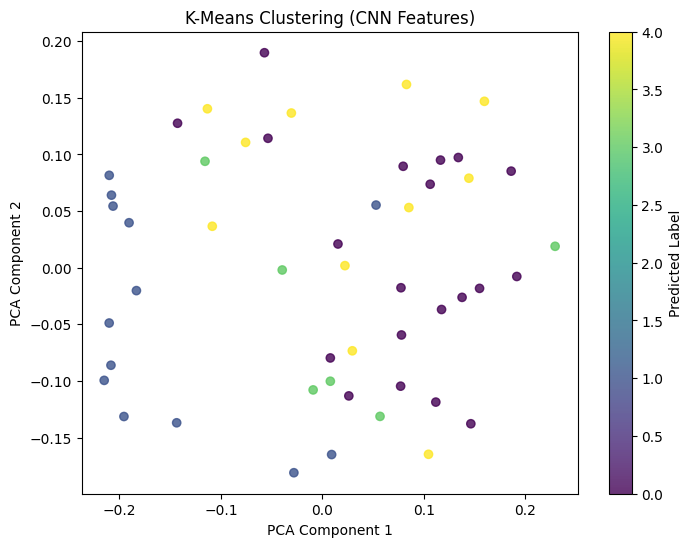

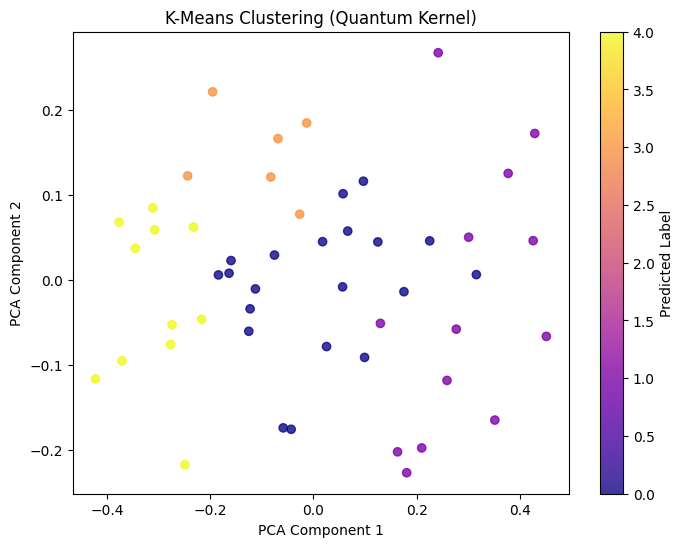

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA

# Load MNIST dataset
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1)  # Reshape for CNN input (28x28 images with 1 channel)
X_train = X_train.astype('float32') / 255.0  # Normalize the images

# Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
selected_classes = [0, 1, 2, 3, 4, 5]
mask = np.isin(y_train, selected_classes)
X_train = X_train[mask]
y_train = y_train[mask]
X_train= X_train[:50]
y_train= y_train[:50]
# Define CNN Model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # Flatten the 3D output to 1D for clustering
])

# Extract features using CNN
cnn_features = cnn_model.predict(X_train)

# Quantum Kernel Setup
n_qubits = 6
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Define Quantum Circuit Components
def feature_map(x):
    """Encodes classical data into a quantum state using RX, RY, and RZ rotations."""
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
        qml.RY(x[i], wires=i)
        qml.RZ(x[i], wires=i)

def entanglement_layer():
    """Applies CZ gates for stronger qubit entanglement."""
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    qml.CZ(wires=[n_qubits - 1, 0])  # Closing the entanglement loop

def variational_ansatz(params):
    """A deeper, more expressive variational quantum circuit."""
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RY(params[l * n_qubits + i], wires=i)
            qml.RX(params[l * n_qubits + i], wires=i)
            qml.RZ(params[l * n_qubits + i], wires=i)
        entanglement_layer()  # Apply entanglement after each layer

@qml.qnode(dev)
def quantum_kernel(x1, x2, params):
    feature_map(x1)
    variational_ansatz(params)
    qml.adjoint(feature_map)(x2)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Optimize the Quantum Kernel for Feature Extraction
def batch_kernel(X, params):
    N = len(X)
    kernel_matrix = np.zeros((N, N, n_qubits))  # Store full qubit measurements

    for i in range(N):
        for j in range(N):
            kernel_matrix[i, j] = quantum_kernel(X[i], X[j], params)
    
    return kernel_matrix.reshape(N, -1)  # Flatten qubit dimensions

# Cost Function
def cost(params, X):
    kernel_matrix = batch_kernel(X, params)
    return np.sum(kernel_matrix)

# Initialize Parameters
params = np.random.rand(n_layers * n_qubits)

# Optimize Using COBYLA
from scipy.optimize import minimize
res = minimize(lambda p: cost(p, cnn_features), params.flatten(), method='COBYLA', options={'maxiter': 10})
params = res.x  # Update parameters

# Compute Optimized Quantum Kernel Matrix
kernel_matrix = batch_kernel(cnn_features, params)

# Perform K-Means Clustering on Quantum Kernel Features
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(kernel_matrix)

# Evaluate clustering performance
silhouette_classical = silhouette_score(cnn_features, kmeans_labels)  # Using CNN Features
silhouette_quantum = silhouette_score(kernel_matrix, kmeans_labels)  # Using Quantum Kernel Features
accuracy = accuracy_score(y_train, kmeans_labels)
print("kmeans_label: ", kmeans_labels)
print("y_train     : ", y_train)
# Print Results
print("Silhouette Score (CNN Features):", silhouette_classical)
print("Silhouette Score (Quantum Kernel):", silhouette_quantum)
print("K-Means Classification Accuracy:", accuracy)

# Map Clusters to MNIST Labels
cluster_to_label = {}
for cluster in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    if len(cluster_indices) > 0:
        cluster_labels = y_train[cluster_indices]
        most_common_label = mode(cluster_labels, keepdims=True).mode[0]
        cluster_to_label[cluster] = most_common_label

# Convert cluster labels to predicted digit classes
y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])
# Compute corrected classification accuracy
accuracy = accuracy_score(y_train, y_pred)
print("y_pred     : ", y_pred)

print("Corrected K-Means Classification Accuracy:", accuracy)
# Visualize the clusters (PCA for 2D projection of CNN features)
pca = PCA(n_components=2)
X_2D_cnn = pca.fit_transform(cnn_features)  # Apply PCA on CNN features
X_2D_quantum = pca.fit_transform(kernel_matrix)  # Apply PCA on quantum kernel features

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_cnn[:, 0], X_2D_cnn[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
plt.colorbar(scatter, label="Predicted Label")
plt.title("K-Means Clustering (CNN Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Visualize Quantum Kernel Clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)
plt.colorbar(scatter, label="Predicted Label")
plt.title("K-Means Clustering (Quantum Kernel)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


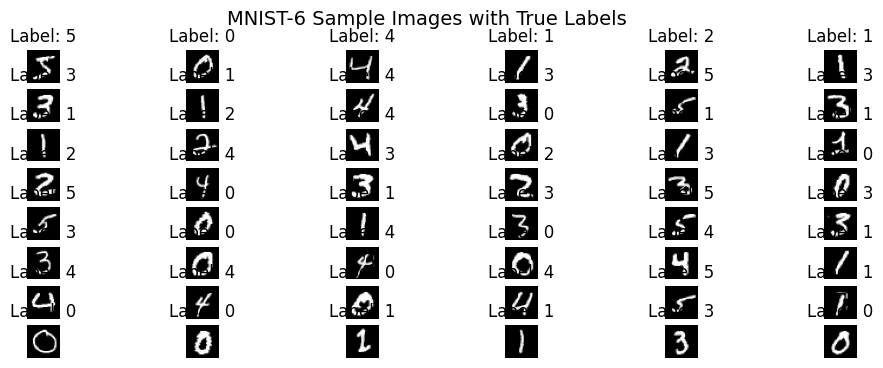

50

In [15]:
# Re-load MNIST dataset and extract 6 classes for visualization
from tensorflow.keras.datasets import mnist

# Load dataset
(X_train, y_train), (_, _) = mnist.load_data()

# Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
selected_classes = [0, 1, 2, 3, 4, 5]
mask = np.isin(y_train, selected_classes)
X_vis, y_vis = X_train[mask], y_train[mask]

# Reduce dataset size for visualization
X_vis, y_vis = X_vis[:size], y_vis[:size]  # Select first 12 images for display

# ✅ Visualizing MNIST-6 Images with True Labels
fig, axes = plt.subplots(8, 6, figsize=(12, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_vis[i], cmap="gray")  # Display as 28x28 grayscale
    ax.set_title(f"Label: {y_vis[i]}")
    ax.axis("off")

plt.suptitle("MNIST-6 Sample Images with True Labels", fontsize=14)
plt.show()
size

(<Figure size 5400x700 with 1 Axes>, <Axes: >)


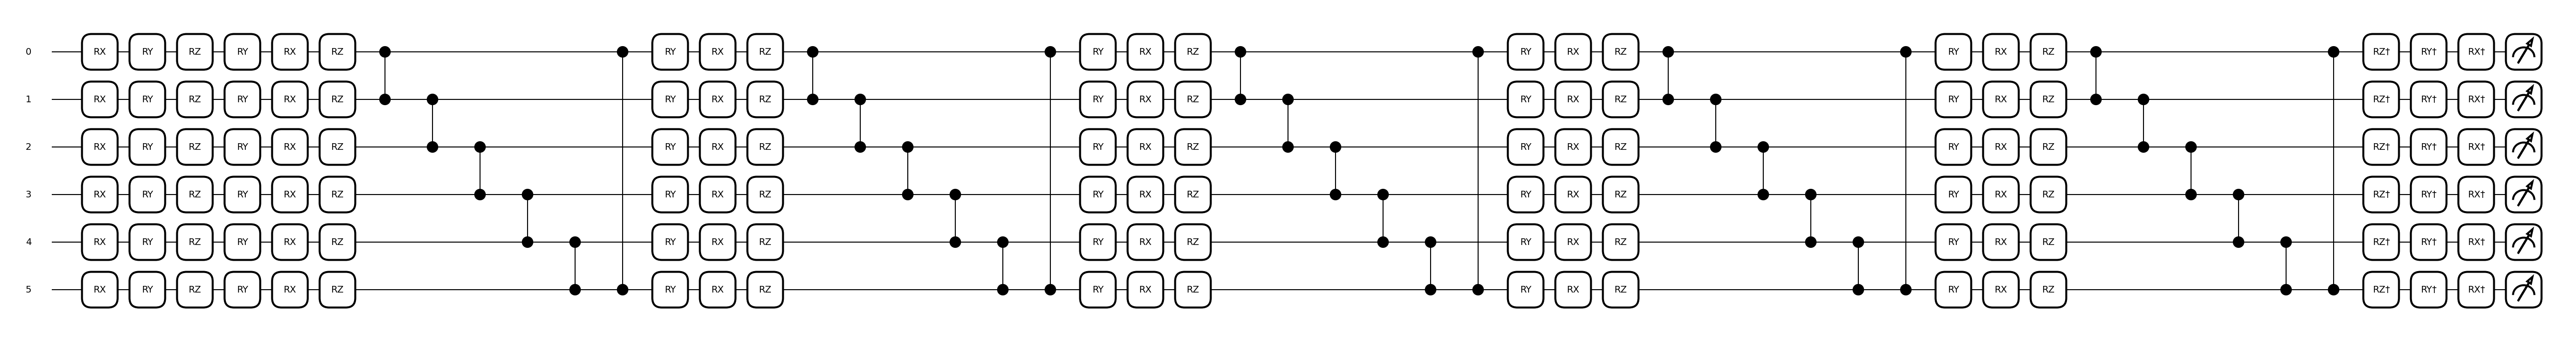

In [9]:
import pennylane as qml
import numpy as np

# Set Quantum Device
n_qubits = 6
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    """Encodes classical data into a quantum state using RX, RY, and RZ rotations."""
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
        qml.RY(x[i], wires=i)
        qml.RZ(x[i], wires=i)

def entanglement_layer():
    """Applies CZ gates for stronger qubit entanglement."""
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    qml.CZ(wires=[n_qubits - 1, 0])  # Closing the entanglement loop

def variational_ansatz(params):
    """A deeper, more expressive variational quantum circuit."""
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RY(params[l * n_qubits + i], wires=i)
            qml.RX(params[l * n_qubits + i], wires=i)
            qml.RZ(params[l * n_qubits + i], wires=i)
        entanglement_layer()  # Apply entanglement after each layer


# Define Quantum Circuit Function
@qml.qnode(dev)
def quantum_circuit_demo(x1, x2, params):
    feature_map(x1)
    variational_ansatz(params)
    qml.adjoint(feature_map)(x2)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Generate a sample input for visualization
sample_x1 = np.random.rand(n_qubits)
sample_x2 = np.random.rand(n_qubits)
sample_params = np.random.rand(n_layers * n_qubits)

# Print the Quantum Circuit
print(qml.draw_mpl(quantum_circuit_demo)(sample_x1, sample_x2, sample_params))


In [31]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.stack([X_train]*3, axis=-1)  # Convert grayscale to 3-channel for ResNet
X_test = np.stack([X_test]*3, axis=-1)  # Convert grayscale to 3-channel for ResNet

# Resize images to match ResNet input (32x32)
X_train = tf.image.resize(X_train, (32, 32)).numpy()
X_test = tf.image.resize(X_test, (32, 32)).numpy()

# Normalize pixel values to range [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Select only digits 0-5
selected_classes = [0, 1, 2, 3, 4, 5]
train_mask = np.isin(y_train, selected_classes)
test_mask = np.isin(y_test, selected_classes)

X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]
X_train= X_train[:5000]
y_train= y_train[:5000]
X_test= X_test[:1000]
y_test= y_test[:1000]
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define ResNet50-based Model for Classification
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze pretrained layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce dimensions
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 classes (digits 0-5)
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Return Accuracy
test_accuracy


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.4968 - loss: 1.4063 - val_accuracy: 0.7870 - val_loss: 0.5843
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8151 - loss: 0.5675 - val_accuracy: 0.8690 - val_loss: 0.4109
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8555 - loss: 0.4337 - val_accuracy: 0.9040 - val_loss: 0.3124
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8626 - loss: 0.4053 - val_accuracy: 0.9170 - val_loss: 0.2710
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8908 - loss: 0.3349 - val_accuracy: 0.9000 - val_loss: 0.3130
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8914 - loss: 0.3316 - val_accuracy: 0.9260 - val_loss: 0.2400
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9054 - loss: 0.2805 - val_accuracy: 0.9320 - val_loss: 0.2177
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9148 - loss: 0.2473 - val_accuracy

0.9210000038146973

In [28]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.stats import mode

# Load MNIST dataset
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = np.stack([X_train]*3, axis=-1)  # Convert grayscale to 3-channel for ResNet
X_train = tf.image.resize(X_train, (32, 32))  # Resize images to match ResNet input
X_train = X_train.numpy().astype('float32') / 255.0  # Normalize

# Select 6 specific classes (digits 0-5)
selected_classes = [0, 1, 2, 3, 4, 5]
mask = np.isin(y_train, selected_classes)
X_train = X_train[mask]
y_train = y_train[mask]
X_train= X_train[:50]
y_train= y_train[:50]
# Define ResNet50 as Feature Extractor
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze the base model

# Create a model to extract features
resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D()  # Reduce dimensions for clustering
])

# Extract Features using ResNet
cnn_features = resnet_model.predict(X_train)

# Perform K-Means Clustering on ResNet-extracted features
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(cnn_features)

# Map Clusters to MNIST Labels
cluster_to_label = {}
for cluster in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    if len(cluster_indices) > 0:
        cluster_labels = y_train[cluster_indices]
        most_common_label = mode(cluster_labels, keepdims=True).mode[0]
        cluster_to_label[cluster] = most_common_label

# Convert cluster labels to predicted digit classes
y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])

# Evaluate clustering performance
silhouette_resnet = silhouette_score(cnn_features, kmeans_labels)  # Using ResNet Features
accuracy_resnet = accuracy_score(y_train, y_pred)

# Return results
accuracy_resnet, silhouette_resnet


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.56, 0.30413678)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_label:  [5 2 5 4 0 3 0 1 0 0 4 5 3 0 5 2 4 0 5 0 0 2 0 0 0 5 3 0 4 5]
y_train     :  [5 0 4 1 2 1 3 1 4 3 5 3 1 2 4 0 1 1 2 4 3 2 3 0 5 0 1 3 5 3]
Silhouette Score (ResNet Features): 0.13441207
Silhouette Score (Quantum Kernel): 0.4001184931789988
K-Means Classification Accuracy: 0.13333333333333333
y_pred     :  [3 0 3 1 3 1 3 1 3 3 1 3 1 3 3 0 1 3 3 3 3 0 3 3 3 3 1 3 1 3]
Corrected K-Means Classification Accuracy: 0.5


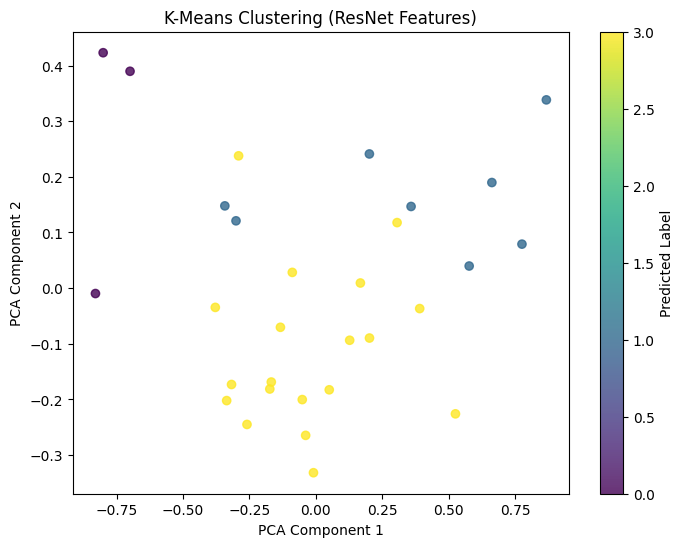

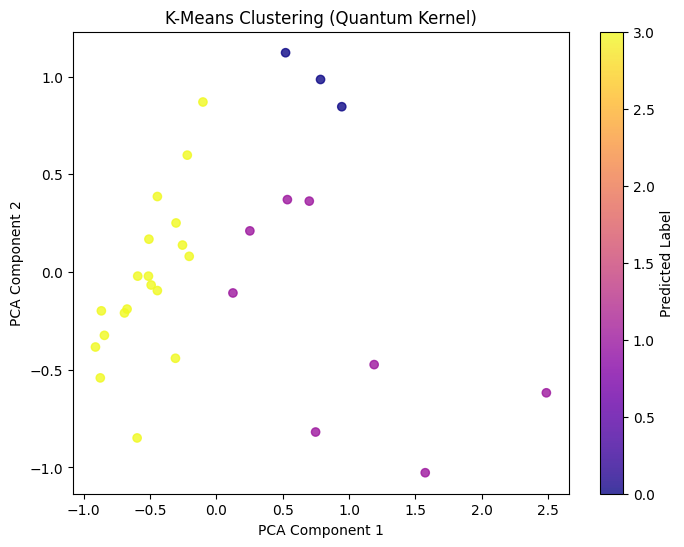

In [49]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA

# Load MNIST dataset
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Convert grayscale images to RGB by duplicating the channel dimension
X_train = np.stack([X_train]*3, axis=-1)  # Convert grayscale to 3-channel
X_train = tf.image.resize(X_train, (32, 32))  # Resize images to match ResNet input
X_train = X_train.numpy().astype('float32') / 255.0  # Normalize the images

# Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
selected_classes = [0, 1, 2, 3, 4, 5]
mask = np.isin(y_train, selected_classes)
X_train = X_train[mask]
y_train = y_train[mask]

# Limit dataset to 100 images for this example
X_train = X_train[:30]
y_train = y_train[:30]

# Load pre-trained ResNet50 model for feature extraction (excluding the classification layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze the base model

# Create a model to extract features from the images
model = models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Reduce dimensions from 2048 to 1
    tf.keras.layers.Dense(6, activation='relu')  # Reduce the output to 6 features
])

# Extract features using ResNet50 (now reduced to 6 features)
resnet_features = model.predict(X_train)

# Extract features using ResNet50
resnet_features = model.predict(X_train)

# Quantum Kernel Setup
n_qubits = 6
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Define Quantum Circuit Components
def feature_map(x):
    """Encodes classical data into a quantum state using RX, RY, and RZ rotations."""
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
        qml.RY(x[i], wires=i)
        qml.RZ(x[i], wires=i)

def entanglement_layer():
    """Applies CZ gates for stronger qubit entanglement."""
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    qml.CZ(wires=[n_qubits - 1, 0])  # Closing the entanglement loop

def variational_ansatz(params):
    """A deeper, more expressive variational quantum circuit."""
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RY(params[l * n_qubits + i], wires=i)
            qml.RX(params[l * n_qubits + i], wires=i)
            qml.RZ(params[l * n_qubits + i], wires=i)
        entanglement_layer()  # Apply entanglement after each layer

@qml.qnode(dev)
def quantum_kernel(x1, x2, params):
    feature_map(x1)
    variational_ansatz(params)
    qml.adjoint(feature_map)(x2)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Optimize the Quantum Kernel for Feature Extraction
def batch_kernel(X, params):
    N = len(X)
    kernel_matrix = np.zeros((N, N, n_qubits))  # Store full qubit measurements

    for i in range(N):
        for j in range(N):
            kernel_matrix[i, j] = quantum_kernel(X[i], X[j], params)
    
    return kernel_matrix.reshape(N, -1)  # Flatten qubit dimensions

# Cost Function
def cost(params, X):
    kernel_matrix = batch_kernel(X, params)
    return np.sum(kernel_matrix)

# Initialize Parameters
params = np.random.rand(n_layers * n_qubits)

# Optimize Using COBYLA
from scipy.optimize import minimize
res = minimize(lambda p: cost(p, resnet_features), params.flatten(), method='COBYLA', options={'maxiter': 10})
params = res.x  # Update parameters

# Compute Optimized Quantum Kernel Matrix
kernel_matrix = batch_kernel(resnet_features, params)

# Perform K-Means Clustering on Quantum Kernel Features
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(kernel_matrix)

# Evaluate clustering performance
silhouette_classical = silhouette_score(resnet_features, kmeans_labels)  # Using ResNet Features
silhouette_quantum = silhouette_score(kernel_matrix, kmeans_labels)  # Using Quantum Kernel Features
accuracy = accuracy_score(y_train, kmeans_labels)

# Print Results
print("kmeans_label: ", kmeans_labels)
print("y_train     : ", y_train)
print("Silhouette Score (ResNet Features):", silhouette_classical)
print("Silhouette Score (Quantum Kernel):", silhouette_quantum)
print("K-Means Classification Accuracy:", accuracy)

# Map Clusters to MNIST Labels
cluster_to_label = {}
for cluster in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    if len(cluster_indices) > 0:
        cluster_labels = y_train[cluster_indices]
        most_common_label = mode(cluster_labels, keepdims=True).mode[0]
        cluster_to_label[cluster] = most_common_label

# Convert cluster labels to predicted digit classes
y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])

# Compute corrected classification accuracy
accuracy = accuracy_score(y_train, y_pred)
print("y_pred     : ", y_pred)
print("Corrected K-Means Classification Accuracy:", accuracy)

# Visualize the clusters (PCA for 2D projection of ResNet features)
pca = PCA(n_components=2)
X_2D_resnet = pca.fit_transform(resnet_features)  # Apply PCA on ResNet features
X_2D_quantum = pca.fit_transform(kernel_matrix)  # Apply PCA on quantum kernel features

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
plt.colorbar(scatter, label="Predicted Label")
plt.title("K-Means Clustering (ResNet Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Visualize Quantum Kernel Clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)
plt.colorbar(scatter, label="Predicted Label")
plt.title("K-Means Clustering (Quantum Kernel)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [40]:
!pip install ace_tools

In [46]:
import pandas as tools


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 924ms/step


100%|██████████| 100/100 [02:55<00:00,  1.76s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00, 1655.86it/s]


Silhouette Score (ResNet Features): 0.25017753
Silhouette Score (Quantum Kernel): 0.3260939452523799
K-Means Classification Accuracy: 0.2
Corrected K-Means Classification Accuracy: 0.59


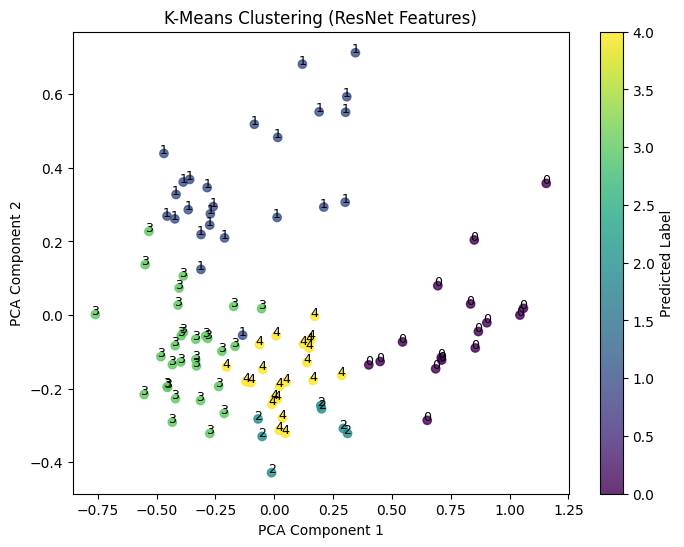

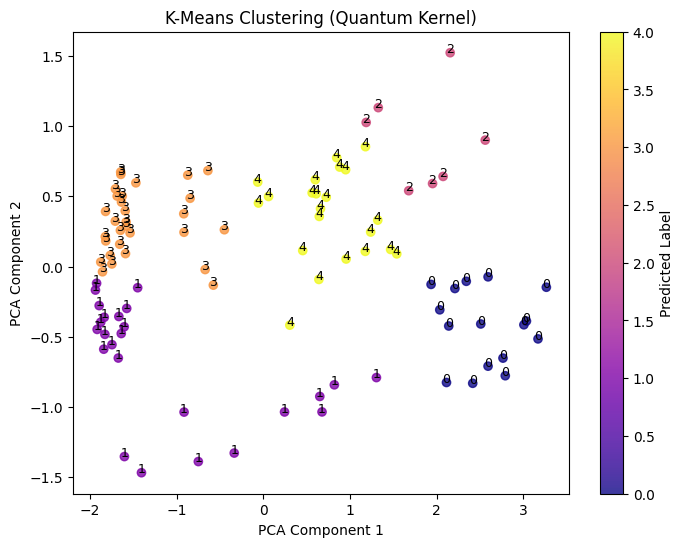

In [58]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from tqdm import tqdm
# Function to load and preprocess the dataset
def load_and_preprocess_data():
    # Load MNIST dataset
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

    # Convert grayscale images to RGB by duplicating the channel dimension
    X_train = np.stack([X_train]*3, axis=-1)  # Convert grayscale to 3-channel
    X_train = tf.image.resize(X_train, (32, 32))  # Resize images to match ResNet input
    X_train = X_train.numpy().astype('float32') / 255.0  # Normalize the images

    # Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
    selected_classes = [0, 1, 2, 3, 4, 5]
    mask = np.isin(y_train, selected_classes)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # Limit dataset to 30 images for this example (you can increase this number)
    X_train = X_train[:100]
    y_train = y_train[:100]

    return X_train, y_train

# Function to define the ResNet50 model for feature extraction
def get_resnet_model():
    # Load pre-trained ResNet50 model for feature extraction (excluding the classification layer)
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze the base model

    # Create a model to extract features from the images
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce dimensions from 2048 to 1
        layers.Dense(6, activation='relu')  # Reduce the output to 6 features
    ])

    return model

# Function to define the quantum kernel setup and related components
def quantum_kernel_setup(n_qubits=6, n_layers=3):
    dev = qml.device("default.qubit", wires=n_qubits)

    def feature_map(x):
        """Encodes classical data into a quantum state using RX, RY, and RZ rotations."""
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)
            qml.RY(x[i], wires=i)
            qml.RZ(x[i], wires=i)

    def entanglement_layer():
        """Applies CZ gates for stronger qubit entanglement."""
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
        qml.CZ(wires=[n_qubits - 1, 0])  # Closing the entanglement loop

    def variational_ansatz(params):
        """A deeper, more expressive variational quantum circuit."""
        for l in range(n_layers):
            for i in range(n_qubits):
                qml.RY(params[l * n_qubits + i], wires=i)
                qml.RX(params[l * n_qubits + i], wires=i)
                qml.RZ(params[l * n_qubits + i], wires=i)
            entanglement_layer()  # Apply entanglement after each layer

    @qml.qnode(dev)
    def quantum_kernel(x1, x2, params):
        feature_map(x1)
        variational_ansatz(params)
        qml.adjoint(feature_map)(x2)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return quantum_kernel

# Function to optimize the quantum kernel and return the kernel matrix
def compute_kernel_matrix(X, params, quantum_kernel):
    N = len(X)
    kernel_matrix = np.zeros((N, N, n_qubits))  # Store full qubit measurements

    for i in tqdm(range(N)):
        for j in range(N):
            kernel_matrix[i, j] = quantum_kernel(X[i], X[j], params)
    
    return kernel_matrix.reshape(N, -1)  # Flatten qubit dimensions

# Cost Function for optimization
def cost(params, X, quantum_kernel):
    kernel_matrix = compute_kernel_matrix(X, params, quantum_kernel)
    return np.sum(kernel_matrix)

# Function to perform clustering and evaluation
def clustering_and_evaluation(kernel_matrix, X, y_train, quantum_kernel):
    # Perform K-Means Clustering on Quantum Kernel Features
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans_labels = kmeans.fit_predict(kernel_matrix)

    # Evaluate clustering performance
    silhouette_classical = silhouette_score(X, kmeans_labels)  # Using ResNet Features
    silhouette_quantum = silhouette_score(kernel_matrix, kmeans_labels)  # Using Quantum Kernel Features
    accuracy = accuracy_score(y_train, kmeans_labels)

    # Map Clusters to MNIST Labels
    cluster_to_label = {}
    for cluster in tqdm(np.unique(kmeans_labels)):
        cluster_indices = np.where(kmeans_labels == cluster)[0]
        if len(cluster_indices) > 0:
            cluster_labels = y_train[cluster_indices]
            most_common_label = mode(cluster_labels, keepdims=True).mode[0]
            cluster_to_label[cluster] = most_common_label

    # Convert cluster labels to predicted digit classes
    y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])

    # Compute corrected classification accuracy
    corrected_accuracy = accuracy_score(y_train, y_pred)
    
    return silhouette_classical, silhouette_quantum, accuracy, corrected_accuracy, y_pred

# Main execution flow
def main():
    # Load and preprocess data
    X_train, y_train = load_and_preprocess_data()

    # Get the ResNet model for feature extraction
    model = get_resnet_model()

    # Extract features using ResNet50
    resnet_features = model.predict(X_train)

    # Quantum Kernel Setup
    quantum_kernel = quantum_kernel_setup()

    # Initialize Parameters for optimization
    params = np.random.rand(n_layers * n_qubits)

    # Optimize Using COBYLA
    res = minimize(lambda p: cost(p, resnet_features, quantum_kernel), params.flatten(), method='COBYLA', options={'maxiter': 10})
    params = res.x  # Update parameters

    # Compute Optimized Quantum Kernel Matrix
    kernel_matrix = compute_kernel_matrix(resnet_features, params, quantum_kernel)

    # Perform clustering and evaluate results
    silhouette_classical, silhouette_quantum, accuracy, corrected_accuracy, y_pred = clustering_and_evaluation(kernel_matrix, resnet_features, y_train, quantum_kernel)

    # Print Results
    print("Silhouette Score (ResNet Features):", silhouette_classical)
    print("Silhouette Score (Quantum Kernel):", silhouette_quantum)
    print("K-Means Classification Accuracy:", accuracy)
    print("Corrected K-Means Classification Accuracy:", corrected_accuracy)

    # Visualize the clusters (PCA for 2D projection)
    pca = PCA(n_components=2)
    X_2D_resnet = pca.fit_transform(resnet_features)  # Apply PCA on ResNet features
    X_2D_quantum = pca.fit_transform(kernel_matrix)  # Apply PCA on quantum kernel features

    # Visualize the clusters (PCA for 2D projection of ResNet features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
    
    # Annotate with the cluster labels (1, 0, 4, etc.)
    for i, label in enumerate(y_pred):
        plt.text(X_2D_resnet[i, 0], X_2D_resnet[i, 1], str(label), fontsize=9, ha='center')
    
    plt.title("K-Means Clustering (ResNet Features)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Predicted Label")
    plt.show()
    
    # Visualize Quantum Kernel Clustering with cluster labels as text
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)
    
    # Annotate with the cluster labels (1, 0, 4, etc.)
    for i, label in enumerate(y_pred):
        plt.text(X_2D_quantum[i, 0], X_2D_quantum[i, 1], str(label), fontsize=9, ha='center')
    
    plt.title("K-Means Clustering (Quantum Kernel)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Predicted Label")
    plt.show()


    # Visualize ResNet Clustering
    # plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
    # plt.colorbar(scatter, label="Predicted Label")
    # plt.title("K-Means Clustering (ResNet Features)")
    # plt.xlabel("PCA Component 1")
    # plt.ylabel("PCA Component 2")
    # plt.show()

    # # Visualize Quantum Kernel Clustering
    # plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)
    # plt.colorbar(scatter, label="Predicted Label")
    # plt.title("K-Means Clustering (Quantum Kernel)")
    # plt.xlabel("PCA Component 1")
    # plt.ylabel("PCA Component 2")
    # plt.show()

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 5/5 [00:00<00:00, 1031.71it/s]


Silhouette Score (ResNet Features): 0.49471575
Silhouette Score (Quantum Kernel): 0.5490132884545478
K-Means Classification Accuracy: 0.4
Corrected K-Means Classification Accuracy: 0.7


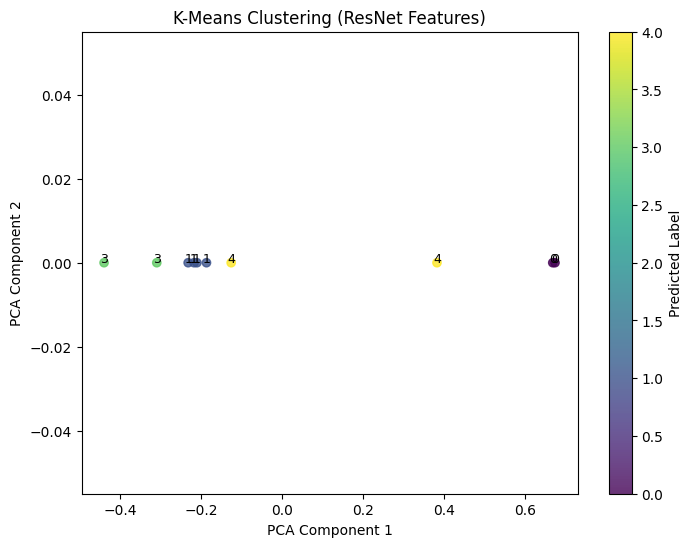

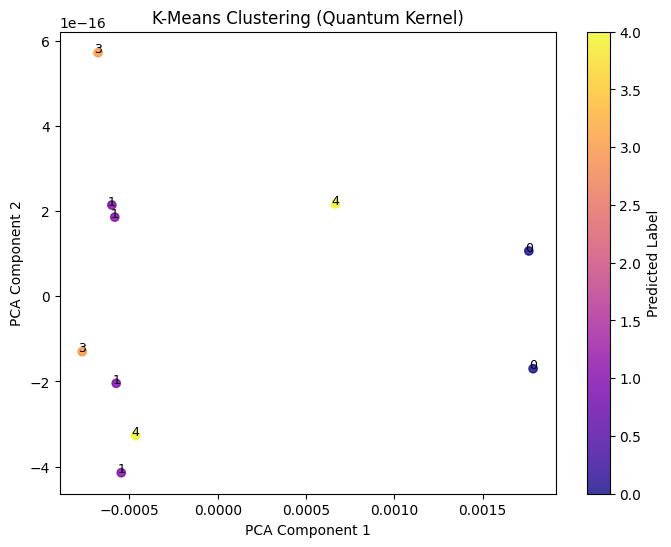

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
n_layers=3
n_qubits=5
# Function to load and preprocess the dataset
def load_and_preprocess_data():
    # Load MNIST dataset
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

    # Convert grayscale images to RGB by duplicating the channel dimension
    X_train = np.stack([X_train]*3, axis=-1)  # Convert grayscale to 3-channel
    X_train = tf.image.resize(X_train, (32, 32))  # Resize images to match ResNet input
    X_train = X_train.numpy().astype('float32') / 255.0  # Normalize the images

    # Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
    selected_classes = [0, 1, 2, 3, 4]
    mask = np.isin(y_train, selected_classes)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # Limit dataset to 30 images for this example (you can increase this number)
    X_train = X_train[:10]
    y_train = y_train[:10]

    return X_train, y_train

# Function to define the ResNet50 model for feature extraction
def get_resnet_model():
    # Load pre-trained ResNet50 model for feature extraction (excluding the classification layer)
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze the base model

    # Create a model to extract features from the images
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce dimensions from 2048 to 1
        layers.Dense(5, activation='relu')  # Reduce the output to 6 features
    ])

    return model

# Function to define the quantum kernel setup and related components
def quantum_kernel_setup(n_qubits=5, n_layers=3):
    dev = qml.device("default.qubit", wires=n_qubits)

    def feature_map(x):
        """Encodes classical data into a quantum state using RX, RY, and RZ rotations."""
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)
            qml.RY(x[i], wires=i)
            qml.RZ(x[i], wires=i)

    def entanglement_layer():
        """Applies CZ gates for stronger qubit entanglement."""
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
        qml.CZ(wires=[n_qubits - 1, 0])  # Closing the entanglement loop

    def variational_ansatz(params):
        """A deeper, more expressive variational quantum circuit."""
        for l in range(n_layers):
            for i in range(n_qubits):
                qml.RY(params[l * n_qubits + i], wires=i)
                qml.RX(params[l * n_qubits + i], wires=i)
                qml.RZ(params[l * n_qubits + i], wires=i)
            entanglement_layer()  # Apply entanglement after each layer

    @qml.qnode(dev)
    def quantum_kernel(x1, x2, params):
        feature_map(x1)
        variational_ansatz(params)
        qml.adjoint(feature_map)(x2)
        return qml.expval(qml.PauliZ(0))

    return quantum_kernel

# Function to optimize the quantum kernel and return the kernel matrix
def compute_kernel_matrix(X, params, quantum_kernel):
    N = len(X)
    kernel_matrix = np.zeros((N, N, n_qubits))  # Store full qubit measurements

    for i in tqdm(range(N)):
        for j in range(N):
            kernel_matrix[i, j] = quantum_kernel(X[i], X[j], params)
    
    return kernel_matrix.reshape(N, -1)  # Flatten qubit dimensions

# Cost Function for optimization
def cost(params, X, quantum_kernel):
    kernel_matrix = compute_kernel_matrix(X, params, quantum_kernel)
    return np.sum(kernel_matrix)

# Function to perform clustering and evaluation
def clustering_and_evaluation(kernel_matrix, X, y_train, quantum_kernel):
    # Perform K-Means Clustering on Quantum Kernel Features
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans_labels = kmeans.fit_predict(kernel_matrix)
    # gmm = GaussianMixture(n_components=5, random_state=42)
    # kmeans_labels = gmm.fit_predict(kernel_matrix)
    # Evaluate clustering performance
    silhouette_classical = silhouette_score(X, kmeans_labels)  # Using ResNet Features
    silhouette_quantum = silhouette_score(kernel_matrix, kmeans_labels)  # Using Quantum Kernel Features
    accuracy = accuracy_score(y_train, kmeans_labels)

    # Map Clusters to MNIST Labels
    cluster_to_label = {}
    for cluster in tqdm(np.unique(kmeans_labels)):
        cluster_indices = np.where(kmeans_labels == cluster)[0]
        if len(cluster_indices) > 0:
            cluster_labels = y_train[cluster_indices]
            most_common_label = mode(cluster_labels, keepdims=True).mode[0]
            cluster_to_label[cluster] = most_common_label

    # Convert cluster labels to predicted digit classes
    y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])

    # Compute corrected classification accuracy
    corrected_accuracy = accuracy_score(y_train, y_pred)
    
    return silhouette_classical, silhouette_quantum, accuracy, corrected_accuracy, y_pred

# Main execution flow
def main():
    # Load and preprocess data
    X_train, y_train = load_and_preprocess_data()

    # Get the ResNet model for feature extraction
    model = get_resnet_model()

    # Extract features using ResNet50
    resnet_features = model.predict(X_train)

    # Quantum Kernel Setup
    quantum_kernel = quantum_kernel_setup()

    # Initialize Parameters for optimization
    params = np.random.rand(n_layers * n_qubits)

    # Optimize Using COBYLA
    res = minimize(lambda p: cost(p, resnet_features, quantum_kernel), params.flatten(), method='COBYLA', options={'maxiter': 10})
    params = res.x  # Update parameters

    # Compute Optimized Quantum Kernel Matrix
    kernel_matrix = compute_kernel_matrix(resnet_features, params, quantum_kernel)

    # Perform clustering and evaluate results
    silhouette_classical, silhouette_quantum, accuracy, corrected_accuracy, y_pred = clustering_and_evaluation(kernel_matrix, resnet_features, y_train, quantum_kernel)

    # Print Results
    print("Silhouette Score (ResNet Features):", silhouette_classical)
    print("Silhouette Score (Quantum Kernel):", silhouette_quantum)
    print("K-Means Classification Accuracy:", accuracy)
    print("Corrected K-Means Classification Accuracy:", corrected_accuracy)

    # Visualize the clusters (PCA for 2D projection)
    pca = PCA(n_components=3)
    X_2D_resnet = pca.fit_transform(resnet_features)  # Apply PCA on ResNet features
    X_2D_quantum = pca.fit_transform(kernel_matrix)  # Apply PCA on quantum kernel features

    # Visualize the clusters (PCA for 2D projection of ResNet features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
    
    # Annotate with the cluster labels (1, 0, 4, etc.)
    for i, label in enumerate(y_pred):
        plt.text(X_2D_resnet[i, 0], X_2D_resnet[i, 1], str(label), fontsize=9, ha='center')
    
    plt.title("K-Means Clustering (ResNet Features)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Predicted Label")
    plt.show()
    
    # Visualize Quantum Kernel Clustering with cluster labels as text
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)
    
    # Annotate with the cluster labels (1, 0, 4, etc.)
    for i, label in enumerate(y_pred):
        plt.text(X_2D_quantum[i, 0], X_2D_quantum[i, 1], str(label), fontsize=9, ha='center')
    
    plt.title("K-Means Clustering (Quantum Kernel)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Predicted Label")
    plt.show()


    # Visualize ResNet Clustering
    # plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
    # plt.colorbar(scatter, label="Predicted Label")
    # plt.title("K-Means Clustering (ResNet Features)")
    # plt.xlabel("PCA Component 1")
    # plt.ylabel("PCA Component 2")
    # plt.show()

    # # Visualize Quantum Kernel Clustering
    # plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)
    # plt.colorbar(scatter, label="Predicted Label")
    # plt.title("K-Means Clustering (Quantum Kernel)")
    # plt.xlabel("PCA Component 1")
    # plt.ylabel("PCA Component 2")
    # plt.show()

if __name__ == "__main__":
    main()


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00, 1890.75it/s]

Silhouette Score (ResNet Features): 0.24600391
K-Means Classification Accuracy: 0.06
Corrected K-Means Classification Accuracy: 0.555


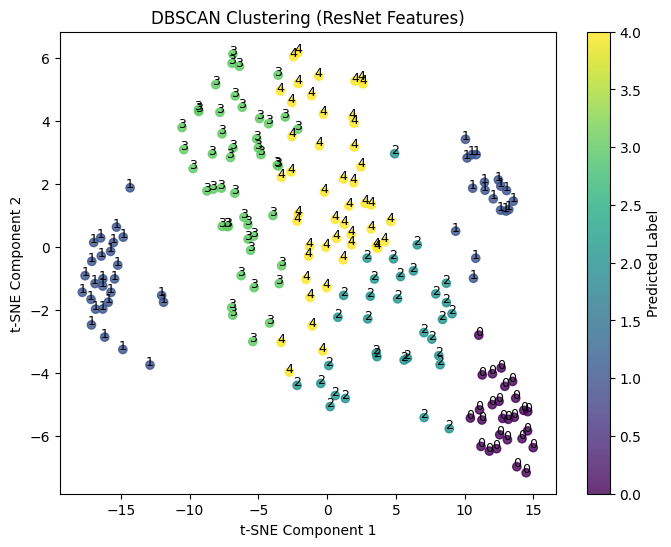

In [78]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to load and preprocess the dataset
def load_and_preprocess_data():
    # Load MNIST dataset
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

    # Convert grayscale images to RGB by duplicating the channel dimension
    X_train = np.stack([X_train] * 3, axis=-1)  # Convert grayscale to 3-channel
    X_train = tf.image.resize(X_train, (32, 32))  # Resize images to match ResNet input
    X_train = X_train.numpy().astype('float32') / 255.0  # Normalize the images

    # Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
    selected_classes = [0, 1, 2, 3, 4, 5]
    mask = np.isin(y_train, selected_classes)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # Limit dataset to 200 images for this example
    X_train = X_train[:200]
    y_train = y_train[:200]

    return X_train, y_train

# Function to define the ResNet50 model for feature extraction
def get_resnet_model():
    # Load pre-trained ResNet50 model for feature extraction (excluding the classification layer)
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze the base model

    # Create a model to extract features from the images
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce dimensions from 2048 to 1D vector
    ])

    return model

# Function to perform clustering and evaluation
# Function to perform clustering and evaluation
def clustering_and_evaluation(features, X, y_train):
    # Perform KMeans Clustering on ResNet Features
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans_labels = kmeans.fit_predict(features)

    # Evaluate clustering performance
    silhouette_classical = silhouette_score(features, kmeans_labels)  # Using ResNet Features
    accuracy = accuracy_score(y_train, kmeans_labels)

    # Map Clusters to MNIST Labels
    cluster_to_label = {}
    for cluster in tqdm(np.unique(kmeans_labels)):
        cluster_indices = np.where(kmeans_labels == cluster)[0]
        if len(cluster_indices) > 0:
            cluster_labels = y_train[cluster_indices]
            most_common_label = mode(cluster_labels, keepdims=True).mode[0]
            cluster_to_label[cluster] = most_common_label

    # Convert cluster labels to predicted digit classes
    y_pred = np.array([cluster_to_label[label] for label in kmeans_labels])

    # Compute corrected classification accuracy
    corrected_accuracy = accuracy_score(y_train, y_pred)
    
    return silhouette_classical, accuracy, corrected_accuracy, y_pred

# Main execution flow
def main():
    # Load and preprocess data
    X_train, y_train = load_and_preprocess_data()

    # Get the ResNet model for feature extraction
    model = get_resnet_model()

    # Extract features using ResNet50
    resnet_features = model.predict(X_train)

    # Flatten the output from ResNet50 (make it 2D: N_samples x N_features)
    resnet_features = resnet_features.reshape(resnet_features.shape[0], -1)

    # Perform clustering and evaluate results
    silhouette_classical, accuracy, corrected_accuracy, y_pred = clustering_and_evaluation(resnet_features, X_train, y_train)

    # Print Results
    print("Silhouette Score (ResNet Features):", silhouette_classical)
    print("K-Means Classification Accuracy:", accuracy)
    print("Corrected K-Means Classification Accuracy:", corrected_accuracy)

    # Visualize the clusters using t-SNE for 2D projection
    tsne = TSNE(n_components=2, random_state=42)
    X_2D_resnet = tsne.fit_transform(resnet_features)  # Apply t-SNE on ResNet features

    # Visualize the clusters (t-SNE for 2D projection of ResNet features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2D_resnet[:, 0], X_2D_resnet[:, 1], c=y_pred, cmap="viridis", alpha=0.8)
    
    # Annotate with the cluster labels (1, 0, 4, etc.)
    for i, label in enumerate(y_pred):
        plt.text(X_2D_resnet[i, 0], X_2D_resnet[i, 1], str(label), fontsize=9, ha='center')
    
    plt.title("DBSCAN Clustering (ResNet Features)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.colorbar(scatter, label="Predicted Label")
    plt.show()

if __name__ == "__main__":
    main()


In [2]:
import numpy as np

# Load the kernel matrix from the .npy file
kernel_matrix = np.load('/kaggle/input/quantum-kernel/kernel_matrix.npy')

# Print the kernel matrix
print(kernel_matrix.shape)


(200, 1600)


In [7]:
import tensorflow as tf
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255.0  # Normalize the images

# Select 6 specific classes (e.g., digits 0, 1, 2, 3, 4, 5)
selected_classes = [0, 1, 2, 3, 4, 5]
mask = np.isin(y_train, selected_classes)
X_train = X_train[mask]
y_train = y_train[mask]
X_train= X_train[:200]
y_train= y_train[:200]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


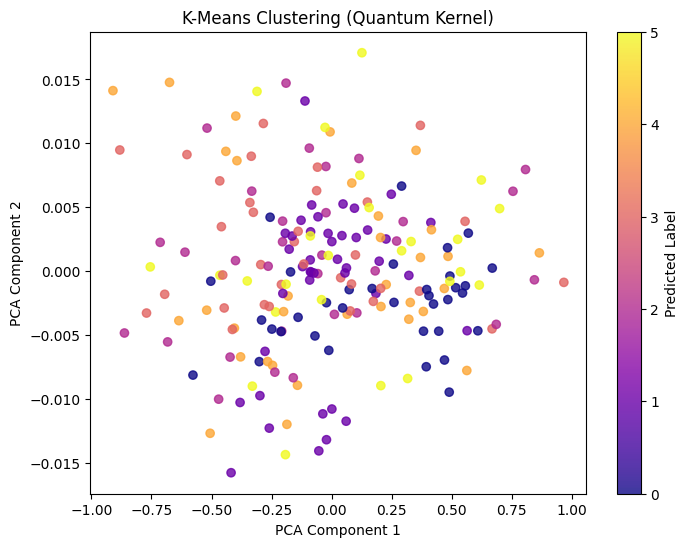

In [9]:
# Visualize the clusters (PCA for 2D projection)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
pca = PCA(n_components=2)
X_2D_quantum = pca.fit_transform(kernel_matrix)  # Apply PCA on quantum kernel features

y_pred=y_train

# Visualize Quantum Kernel Clustering with cluster labels as text
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D_quantum[:, 0], X_2D_quantum[:, 1], c=y_pred, cmap="plasma", alpha=0.8)

plt.title("K-Means Clustering (Quantum Kernel)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Predicted Label")
plt.show()

In [2]:
!pip install qiskit

In [5]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=696d6c6ad6fa7a70516927e4f208486c6b023b10e87a25b4efabe7466aca4aea
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout, circuit_drawer
import matplotlib.pyplot as plt

# Define the quantum circuit with 5 qubits and 5 classical bits for measurement
qc = QuantumCircuit(5, 5)

# Apply Hadamard gates (Blue)
qc.h(1)
qc.h(2)

# Apply X, Y, Z, and S gates (Green)
qc.x(0)
qc.y(4)
qc.z(3)
qc.s(3)

# Apply controlled-X (CNOT) gates (Blue)
qc.cx(0, 1)
qc.cx(0, 4)

# Apply T and T† (Red)
qc.t(2)
qc.tdg(2)

# Apply another layer of Hadamard and S† gates (Blue/Green)
qc.h(1)
qc.sdg(3)

# Apply additional X and Y gates
qc.x(0)
qc.y(4)

# Apply measurement (Magenta)
qc.measure(range(5), range(5))

# Draw the circuit
qc.draw(output='mpl', style={'name': 'iqp'}) 
plt.show()

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."